# Data Wrangling for Santa Clara Master Gardener Club by Michelle Petersen

In [148]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import json
import geojson
import shapefile
import requests
from bs4 import BeautifulSoup
import difflib
import geopandas as gpd
import pprint 
import six.moves.urllib as urllib
import matplotlib.pyplot as plt
from timeit import default_timer as timer

## Gather

In [5]:
df = gpd.read_file('ZillowNeighborhoods-CA/ZillowNeighborhoods-CA.shp')
print(df)

     State          County            City                         Name  \
0       CA       Riverside         Menifee                     Sun City   
1       CA     Santa Clara        San Jose                       Alviso   
2       CA           Marin      San Rafael                Santa Venetia   
3       CA           Marin      San Rafael                    Marinwood   
4       CA     Los Angeles   Santa Clarita                      Newhall   
5       CA     Los Angeles     Los Angeles                      Tujunga   
6       CA         Ventura          Oxnard                     Cabrillo   
7       CA     Los Angeles     Los Angeles                 Shadow Hills   
8       CA     Los Angeles     Los Angeles                       Sylmar   
9       CA   San Francisco   San Francisco                     Presidio   
10      CA     Los Angeles   Santa Clarita               Canyon Country   
11      CA         Alameda         Alameda                     East End   
12      CA       San Mate

In [6]:
df.to_csv('California neighborhoods.csv')

In [7]:
sc_df = df[df['County'] == 'Santa Clara']
print(sc_df)

     State       County           City                      Name RegionID  \
1       CA  Santa Clara       San Jose                    Alviso     8075   
22      CA  Santa Clara       San Jose             Cambrian Park   114074   
42      CA  Santa Clara      Cupertino          Rancho Rinconada   117559   
43      CA  Santa Clara       Campbell                 San Tomas   117891   
68      CA  Santa Clara       San Jose                 Berryessa   113736   
74      CA  Santa Clara       San Jose                 Evergreen   115003   
94      CA  Santa Clara  Mountain View            Blossom Valley     3707   
129     CA  Santa Clara      Los Altos                    Loyola   116334   
207     CA  Santa Clara       Campbell                      Dell   178814   
213     CA  Santa Clara       San Jose               Willow Glen   118987   
241     CA  Santa Clara      Cupertino                Oak Valley   189743   
242     CA  Santa Clara      Sunnyvale                 Ponderosa   191799   

In [8]:
sc_df.to_csv('Santa Clara neighborhoods.csv')

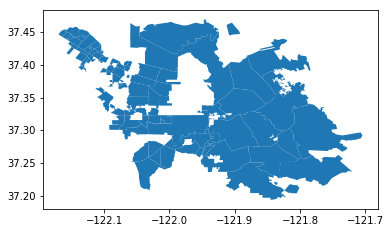

In [9]:
sc_df.plot()

## Assess

In [10]:
import gspread
from google.oauth2 import service_account
from google.auth.transport.requests import AuthorizedSession

# The scope to read the spreadsheet
_GS_SCOPE = ['https://www.googleapis.com/auth/spreadsheets.readonly',
            'https://www.googleapis.com/auth/drive']

# The ID and range of the MasterGardener spreadsheet.
_GS_ID = '1pPOuRZ9YsKwXGKgxzSm9tXCR_dgkCY4WNh3rg_cFX08'

service_account_info = json.load(open('Master Gardener-7e906e507d9d.json'))
credentials = service_account.Credentials.from_service_account_info(
    service_account_info,
    scopes=_GS_SCOPE)

if credentials:
    gc = gspread.Client(auth=credentials)
    gc.session = AuthorizedSession(credentials)
    book = gc.open_by_key(_GS_ID)
    print(book.title)
    worksheet_list = book.worksheets()
    for worksheet in worksheet_list:
        print(worksheet)

Santa Clara County Master Gardeners
<Worksheet 'Contacts' id:0>
<Worksheet 'Contact-Neighborhood Mapping' id:1541812186>
<Worksheet 'Zillow Neighborhoods' id:1790253258>
<Worksheet 'Google Neighborhoods' id:1302983281>
<Worksheet 'Nextdoor Neighborhoods' id:284535610>


In [34]:
df_contacts = pd.DataFrame(book.get_worksheet(0).get_all_values())
df_contact_neighborhood = pd.DataFrame(book.get_worksheet(1).get_all_values())
df_zillow_neighborhoods = pd.DataFrame(book.get_worksheet(2).get_all_values())
df_nextdoor_neighborhoods = pd.DataFrame(book.get_worksheet(4).get_all_values())

In [35]:
df_contacts.head()

,0,1,2,3,4
0,Name,e-mail,Residence - Nextdoor Neighborhood,Unknown Neighborhood,Notes
1,Anita Rosen,anita@readygo.com,Gemello,FALSE,
2,Ann Ranish,annranish@gmail.com,Starbird,FALSE,
3,Carol Peck,CAnative.carol@gmail.com,Gilroy,FALSE,Northern Gilroy?
4,Don Krafft,dfk@donkrafft.com,Morse Park,FALSE,Sunnyvale


In [36]:
df_contacts.reset_index()
df_contacts.columns = ['Name', 'email', 'Residence - Nextdoor Neighborhood', 'Unknown Neighborhood', 'Notes']

In [37]:
df_contacts = df_contacts[df_contacts['Name'] != 'Name']

In [38]:
df_contacts['Residence - Nextdoor Neighborhood'] = df_contacts['Residence - Nextdoor Neighborhood'].str.title()

In [39]:
df_contacts.head()

,Name,email,Residence - Nextdoor Neighborhood,Unknown Neighborhood,Notes
1,Anita Rosen,anita@readygo.com,Gemello,FALSE,
2,Ann Ranish,annranish@gmail.com,Starbird,FALSE,
3,Carol Peck,CAnative.carol@gmail.com,Gilroy,FALSE,Northern Gilroy?
4,Don Krafft,dfk@donkrafft.com,Morse Park,FALSE,Sunnyvale
5,Jeff Jenks,jenks.jeff@gmail.com,Monta Vista,FALSE,Cupertino


In [40]:
df_contact_neighborhood.head()

,0,1,2
0,Allie Judy,San Tomas,FALSE
1,Allie Judy,Newport Apartments,FALSE
2,Allie Judy,Hacienda,FALSE
3,Allie Judy,Pollard Road,FALSE
4,Allie Judy,Los Gatos Woods,FALSE


In [41]:
df_contact_neighborhood.reset_index()
df_contact_neighborhood.columns = ['Name', 'Nextdoor Neighborhood', 'Unknown Neighborhood']

In [42]:
df_contact_neighborhood = df_contact_neighborhood[df_contact_neighborhood['Name'] != 'Name']

In [43]:
df_contact_neighborhood.head()

,Name,Nextdoor Neighborhood,Unknown Neighborhood
0,Allie Judy,San Tomas,FALSE
1,Allie Judy,Newport Apartments,FALSE
2,Allie Judy,Hacienda,FALSE
3,Allie Judy,Pollard Road,FALSE
4,Allie Judy,Los Gatos Woods,FALSE


In [44]:
df_contact_neighborhood['Nextdoor Neighborhood'] = df_contact_neighborhood['Nextdoor Neighborhood'].str.title()

In [45]:
df_contact_neighborhood.head()

,Name,Nextdoor Neighborhood,Unknown Neighborhood
0,Allie Judy,San Tomas,FALSE
1,Allie Judy,Newport Apartments,FALSE
2,Allie Judy,Hacienda,FALSE
3,Allie Judy,Pollard Road,FALSE
4,Allie Judy,Los Gatos Woods,FALSE


In [46]:
df_nextdoor_neighborhoods.head()

,0,1,2,3,4
0,State,County,City,Neighborhood,link
1,CA,Santa Clara,San Jose,Albanese Circle,https://nextdoor.com/neighborhood/albanesecirc...
2,CA,Santa Clara,San Jose,Almaden,https://nextdoor.com/neighborhood/almadenca--s...
3,CA,Santa Clara,San Jose,Alvin/Burdette,https://nextdoor.com/neighborhood/7alvinburdet...
4,CA,Santa Clara,San Jose,Alviso,https://nextdoor.com/neighborhood/4alviso--san...


In [47]:
df_nextdoor_neighborhoods.reset_index()
df_nextdoor_neighborhoods.columns = ['State', 'County', 'City', 'Neighborhood', 'Link']

In [48]:
df_nextdoor_neighborhoods = df_nextdoor_neighborhoods[df_nextdoor_neighborhoods['Neighborhood'] != 'Neighborhood']

In [49]:
df_nextdoor_neighborhoods.head()

,State,County,City,Neighborhood,Link
1,CA,Santa Clara,San Jose,Albanese Circle,https://nextdoor.com/neighborhood/albanesecirc...
2,CA,Santa Clara,San Jose,Almaden,https://nextdoor.com/neighborhood/almadenca--s...
3,CA,Santa Clara,San Jose,Alvin/Burdette,https://nextdoor.com/neighborhood/7alvinburdet...
4,CA,Santa Clara,San Jose,Alviso,https://nextdoor.com/neighborhood/4alviso--san...
5,CA,Santa Clara,San Jose,Anne Darling - Little Portugal North,https://nextdoor.com/neighborhood/3littleportu...


In [61]:
df_contact_neighborhood.head()

,Name,Nextdoor Neighborhood,Unknown Neighborhood,Similar Google Neighborhood
1,Allie Judy,San Tomas,FALSE,[San Tomas]
2,Allie Judy,Newport Apartments,FALSE,[]
3,Allie Judy,Hacienda,FALSE,[]
4,Allie Judy,Pollard Road,FALSE,[]
5,Allie Judy,Los Gatos Woods,FALSE,[]


In [50]:
df_zillow_neighborhoods.head()

,0,1,2,3,4,5
0,State,County,City,Neighborhood,RegionID,geometry
1,CA,Santa Clara,San Jose,Alviso,8075,POLYGON ((-121.9423569999999 37.46496300000007...
2,CA,Santa Clara,San Jose,Cambrian Park,114074,"POLYGON ((-121.878978755 37.27530488000008, -1..."
3,CA,Santa Clara,Cupertino,Rancho Rinconada,117559,"POLYGON ((-122.00649 37.32295, -122.004603875 ..."
4,CA,Santa Clara,Campbell,San Tomas,117891,POLYGON ((-121.9526834979999 37.27366922400006...


In [51]:
df_zillow_neighborhoods.reset_index()
df_zillow_neighborhoods.columns = ['State', 'County', 'City', 'Neighborhood', 'RegionID', 'Geometry']

In [52]:
df_zillow_neighborhoods = df_zillow_neighborhoods[df_zillow_neighborhoods['Neighborhood'] != 'Neighborhood']

In [53]:
df_zillow_neighborhoods.head()

,State,County,City,Neighborhood,RegionID,Geometry
1,CA,Santa Clara,San Jose,Alviso,8075,POLYGON ((-121.9423569999999 37.46496300000007...
2,CA,Santa Clara,San Jose,Cambrian Park,114074,"POLYGON ((-121.878978755 37.27530488000008, -1..."
3,CA,Santa Clara,Cupertino,Rancho Rinconada,117559,"POLYGON ((-122.00649 37.32295, -122.004603875 ..."
4,CA,Santa Clara,Campbell,San Tomas,117891,POLYGON ((-121.9526834979999 37.27366922400006...
5,CA,Santa Clara,San Jose,Berryessa,113736,POLYGON ((-121.8202519999999 37.43812700000007...


In [54]:
df_contacts.to_csv('mg_contacts_master.csv', index=False)
df_contact_neighborhood.to_csv('mg_contact_neighborhood_master.csv', index=False)

## Scraping Nextdoor Neighborhoods

In [77]:
state = 'CA'
state_url = 'https://nextdoor.com/find-neighborhood/' + state + '/'

In [78]:
from requests import get
response = requests.get(state_url)
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [79]:
hood_city_group = html_soup.find_all('div', class_ = 'hood_group')
print(type(hood_city_group))
print(len(hood_city_group))

<class 'bs4.element.ResultSet'>
24


In [80]:
df_cities = pd.DataFrame(index=range(5000), columns = ['State', 'City', 'Link'])
df_loc = 0
df_cities.head(1)

,State,City,Link
0,NaN,NaN,NaN


for div in hood_city_group:
    city_links = div.findAll('a')
    for a in city_links:
        df_cities.iloc[df_loc, df_cities.columns.get_loc("State")] = 'CA'
        df_cities.iloc[df_loc, df_cities.columns.get_loc("City")] = a.string
        df_cities.iloc[df_loc, df_cities.columns.get_loc("Link")] = a['href'].strip()
        df_loc += 1

df_cities.dropna(axis = 0, inplace=True)
print(df_loc)

df_cities.reindex(columns=['State','County','City', 'Link'])
df_cities.head(1)

df_cities.to_csv('mg_nextdoor_california_cities.csv', index=False)

In [84]:
cities = ['San Jose','Santa Clara','Sunnyvale', 'Palo Alto','Mountain View',\
          'Cupertino','Milpitas','Los Gatos', 'Gilroy', 'Morgan Hill', 'Campbell',\
          'Los Altos','Saratoga', 'Stanford', 'Los Altos Hills',\
          'San Martin']

df_nextdoor_neighborhoods = pd.DataFrame(index=range(7000), columns = ['State', 'County', 'City', 'Neighborhood', 'Link'])
df_loc = 0
df_nextdoor_neighborhoods.head(1)

for city in cities:
    print(city)
    city_lookup = df_cities[df_cities['City'] == city]["Link"].values[0]
    print(city_lookup)
    response = requests.get(city_lookup)
    responseTxt = response.text.encode('UTF-8')
    html_soup = BeautifulSoup(responseTxt, 'html.parser')
    type(html_soup) 
    hood_neighborhood_group = html_soup.find_all('div', class_ = 'hood_group')
    print(type(hood_neighborhood_group))
    print(len(hood_neighborhood_group))
   
    for div in hood_neighborhood_group:
        neighborhood_links = div.findAll('a')
        for a in neighborhood_links:
            print(city + " " + a.string + " " +  a['href'])
            df_nextdoor_neighborhoods.iloc[df_loc, df_nextdoor_neighborhoods.columns.get_loc("State")] = 'CA'
            df_nextdoor_neighborhoods.iloc[df_loc, df_nextdoor_neighborhoods.columns.get_loc("County")] = 'Santa Clara'
            df_nextdoor_neighborhoods.iloc[df_loc, df_nextdoor_neighborhoods.columns.get_loc("City")] = city
            df_nextdoor_neighborhoods.iloc[df_loc, df_nextdoor_neighborhoods.columns.get_loc("Neighborhood")] = str(a.string.encode('UTF-8'))
            df_nextdoor_neighborhoods.iloc[df_loc, df_nextdoor_neighborhoods.columns.get_loc("Link")] = str(a['href'].strip())
            df_loc += 1

df_nextdoor_neighborhoods.dropna(axis = 0, inplace=True)
print(df_loc)

df_nextdoor_neighborhoods.head(3)

df_nextdoor_neighborhoods.to_csv('mg_nextdoor_neighborhoods_master.csv', index=False)

In [55]:
df_contact_neighborhood['Similar Nextdoor Neighborhood'] = 'None'
df_contacts['Similar Nextdoor Neighborhood'] = 'None'

In [56]:
neighborhoods = list(df_nextdoor_neighborhoods['Neighborhood'])
for index, row in df_contact_neighborhood.iterrows():
    row['Similar Nextdoor Neighborhood'] = difflib.get_close_matches(row['Nextdoor Neighborhood'].lower(), neighborhoods)

In [57]:
for index, row in df_contacts.iterrows():
    row['Similar Nextdoor Neighborhood'] = difflib.get_close_matches(row['Residence - Nextdoor Neighborhood'].lower(), neighborhoods)

In [58]:
df_contacts.head(1)

,Name,email,Residence - Nextdoor Neighborhood,Unknown Neighborhood,Notes,Similar Nextdoor Neighborhood
1,Anita Rosen,anita@readygo.com,Gemello,FALSE,,[Gemello]


In [59]:
df_contact_neighborhood.head(1)

,Name,Nextdoor Neighborhood,Unknown Neighborhood,Similar Nextdoor Neighborhood
0,Allie Judy,San Tomas,FALSE,[San Tomas]


In [60]:
df_contact_neighborhood['Nextdoor Neighborhood'].nunique()

319

In [61]:
df_contact_neighborhood['Nextdoor Neighborhood'].value_counts()

Upper Sierra                        3
Mccollam                            2
Woodland Acres                      2
Summerdale                          2
Sunshine                            2
Pollard Road                        2
Piedmont                            2
Old Mountain View                   2
Remington                           2
Cumberland South                    2
Cuesta Park                         2
Coyote Creek                        2
Village Green                       2
Varsity Park                        2
Lowlanders                          2
Somerset Knolls                     2
Sunnyvale                           2
North Los Gatos                     2
Boulder                             2
Rinconada Hills                     2
Saratoga Village                    2
Westgate Village                    2
San Tomas                           2
Los Gatos Woods                     2
Rinconada                           2
Los Altos Hills Town Hall Circle    2
Sobrato     

In [62]:
df_contacts.to_csv('mg_contacts_master.csv', index=False)
df_contact_neighborhood.to_csv('mg_contact_neighborhood_master.csv', index=False)

In [65]:
_GM_API_KEY = '#####'

df_nextdoor_neighborhoods['Similar Google Neighborhood'] = 'None'
df_nextdoor_neighborhoods['Google Place ID'] = 'None'
#df_nextdoor_neighborhoods[Google Location = 'None'

import six.moves.urllib as urllib

for index, row in df_nextdoor_neighborhoods.iterrows():
    neighborhoodquery = urllib.parse.quote(row["Neighborhood"] + ', ' +  row["City"] + ', ' +  row["State"], safe='')
    print(neighborhoodquery)
    response = requests.get('https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input=' + neighborhoodquery + '&inputtype=textquery&fields=name,id,place_id,plus_code,types,geometry&key=' + _GM_API_KEY)
    resp_json_payload = response.json()
    print(resp_json_payload)                                           
    for k, v in resp_json_payload.items():
        print(k)
        if ((k == 'candidates') & (len(v) > 0)):
            for pair in v:
                if (('neighborhood' == pair['types'][0]) or ('locality' in pair['types'][0])):
                    if ('political' == pair['types'][1]):
                        print(pair['name'])
                        print(pair['place_id'])
                        row["Similar Google Neighborhood"] = pair['name']
                        row["Google Place ID"] = pair['place_id']

In [91]:
df_nextdoor_neighborhoods.head(3)

,State,County,City,Neighborhood,Link,Similar Google Neighborhood,Google Place ID,Hood Name,Hood ID,GeoJSON,Interests,Homeowners,Population,Average Age,Attributes
1,CA,Santa Clara,San Jose,Albanese Circle,https://nextdoor.com/neighborhood/albanesecirc...,None,None,None,None,None,None,None,None,None,None
2,CA,Santa Clara,San Jose,Almaden,https://nextdoor.com/neighborhood/almadenca--s...,Almaden,ChIJ8RtyWWkwjoARKOALmJ4lSgU,None,None,None,None,None,None,None,None
3,CA,Santa Clara,San Jose,Alvin/Burdette,https://nextdoor.com/neighborhood/7alvinburdet...,Alvin - Burdette,ChIJn5Y5-ZUyjoARiM0tE09NqXY,None,None,None,None,None,None,None,None


In [69]:
df_nextdoor_neighborhoods.to_csv('mg_nextdoor_with_google_master.csv', index=False)

## Parsing geoJSON

In [75]:
df_nextdoor_neighborhoods["Hood Name"] = 'None'
df_nextdoor_neighborhoods["Hood ID"] = 'None'
df_nextdoor_neighborhoods["GeoJSON"] = 'None'
df_nextdoor_neighborhoods["Interests"] = 'None'
df_nextdoor_neighborhoods["Gardening Interest"] = 0
df_nextdoor_neighborhoods["Homeowners"] = 'None'
df_nextdoor_neighborhoods["Population"] = 'None'
df_nextdoor_neighborhoods["Average Age"] = 'None'
df_nextdoor_neighborhoods['Attributes'] = 'None'

In [183]:
#for index, row in df_nextdoor_neighborhoods.iterrows():
row = df_nextdoor_neighborhoods.iloc[1]
print(row)
neighborhood_lookup = row["Link"]
print(neighborhood_lookup)
response = requests.get(neighborhood_lookup)
responseTxt = response.text.encode('UTF-8')
html_soup = BeautifulSoup(responseTxt, 'html.parser')

State                                                                         CA
County                                                               Santa Clara
City                                                                    San Jose
Neighborhood                                                             Almaden
Link                           https://nextdoor.com/neighborhood/almadenca--s...
Similar Google Neighborhood                                              Almaden
Google Place ID                                      ChIJ8RtyWWkwjoARKOALmJ4lSgU
Hood Name                                                                   None
Hood ID                                                                     None
GeoJSON                                                                     None
Interests                                                                   None
Homeowners                                                                  None
Population                  

In [184]:
scripts = html_soup.findAll('script')
neighborhood_info = scripts[5].string.strip()
neighborhood_info = neighborhood_info[neighborhood_info.index('['):-1]
print(neighborhood_info)

[{"agencyName": "Santa Clara Valley Water District", "hostname": "almadenca", "subject": "Temporary Bay Trail Closure in East Palo Alto", "postId": "101458364", "urlSlug": "santa-clara-valley-water-district-1", "avatarPhoto": "https://d3926qxcw0e1bh.cloudfront.net/pages_avatar_photos/01/03/010310b823d05ffa89499baf1d1221f8.jpg", "groupId": "1458946"}, {"agencyName": "San Jos\u00e9 City Council", "hostname": "almadenca", "subject": "Join CM Carrasco tomorrow! 1st Pancake Breakfast of the year!", "postId": "101447625", "urlSlug": "san-jose-city-council", "avatarPhoto": "https://d3926qxcw0e1bh.cloudfront.net/pages_avatar_photos/fc/92/fc923118a79f09820c9a021fc54a6087.jpg", "groupId": "533104"}, {"agencyName": "San Jos\u00e9 City Council", "hostname": "almadenca", "subject": "Join me tomorrow! 1st Pancake Breakfast of the year!", "postId": "101447354", "urlSlug": "san-jose-city-council", "avatarPhoto": "https://d3926qxcw0e1bh.cloudfront.net/pages_avatar_photos/fc/92/fc923118a79f09820c9a021fc

In [185]:
neighborhoodGeometries = neighborhood_info[neighborhood_info.index('neighborhoodGeometriesJSON: '): neighborhood_info.index('neighborhoodMapOptions:{')]
neighborhoodGeometries = neighborhoodGeometries.lstrip()
neighborhoodGeometries = neighborhoodGeometries.rstrip()
begIndex = len('neighborhoodGeometriesJSON: ')
neighborhoodGeometries = neighborhoodGeometries[begIndex: -1]
neighborhood_json = json.loads(neighborhoodGeometries)

In [186]:
def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += len(sub) # use start += 1 to find overlapping matches

In [187]:
begIndexes = list(find_all(neighborhood_info, "\"page_url\": \"")) 
endIndexes = list(find_all(neighborhood_info, "\", \"short_name\": ")) 
print(begIndexes)
print(endIndexes)
print(neighborhood_info[116734 + len ("\"page_url\": \""): 116806]) 

[64146, 66460, 67307, 68461, 71558, 72814, 75074, 76006, 77000, 78456, 79930, 81663, 82847, 84688, 86065, 88233, 91076, 93015, 95229, 98305, 100315, 101603, 104979, 106484, 108132, 110499, 112009, 116840, 118981]
[64219, 66545, 67377, 68535, 71631, 72896, 75159, 76079, 77073, 78541, 80010, 81748, 82921, 84763, 86142, 88302, 91157, 93087, 95310, 98384, 100387, 101680, 105053, 106563, 108211, 110580, 112086, 116911, 119046]
787250607747, 37.21516710784651]]]]}", "centroid": [-121.82


In [188]:
feature = neighborhood_json["features"][3]
feature['properties']['State'] = 'CA'
feature['properties']['City'] = 'San Jose'
feature['properties']['County'] = 'Santa Clara'
pp.pprint(feature)

{   'geometry': {   'coordinates': [   [   [   [   -121.89473459850296,
                                                   37.22925687092096],
                                               [   -121.8942930692894,
                                                   37.229076150478946],
                                               [   -121.89336874245316,
                                                   37.22886126059521],
                                               [   -121.89273233459778,
                                                   37.2287969228329],
                                               [   -121.89035785530075,
                                                   37.22877529795784],
                                               [   -121.88559189142688,
                                                   37.22821620038667],
                                               [   -121.88443081646903,
                                                   37.228169660549796],

In [189]:
print(len(neighborhood_json["features"]))

30


In [190]:
try:
    begCensusIndex = neighborhood_info.index('census: {')
    endCensusIndex = neighborhood_info.index('city: ')
    if ((begCensusIndex > 0) and (endCensusIndex > 0)):
        census = neighborhood_info[begCensusIndex: endCensusIndex]
        census = census[census.index('{'): census.index('}')+1]
        census = json.loads(census)
        print(census['homeowners'])
        print(census['population'])
        print(census['age'])
except:
    print("No census found for: %s", row["Hood Name"])

92
3267
57


In [208]:
try:
    begInterestIndex = neighborhood_info.index('interests: [')
    endInterestIndex = neighborhood_info.index('iosUrl: "https://')
    if ((begInterestIndex > 0) and (endInterestIndex > 0)):
        interests = neighborhood_info[begInterestIndex: endInterestIndex]
        interests = interests[interests.index('[') +1: interests.index(']')]
        interests = interests.replace('"', "")
        interest_list = interests.split(", ")
        print("Interests: %s\n" % interests)
        print(interest_list.index('Gardening & Landscape'))
except:
    print("No interests found for: %s", row["Hood Name"])

Interests: Hiking & Trails, Gardening & Landscape, Walking, Cooking, Seeing Live Music, Home Improvement & DIY, Books, Dogs, Family Activities, Volunteering

1


In [207]:
interests = interests.replace('"', "")
print(interests)
my_list = interests.split(", ")
print(my_list)
print(my_list.index('Gardening & Landscape'))

Hiking & Trails, Gardening & Landscape, Walking, Cooking, Seeing Live Music, Home Improvement & DIY, Books, Dogs, Family Activities, Volunteering
['Hiking & Trails', 'Gardening & Landscape', 'Walking', 'Cooking', 'Seeing Live Music', 'Home Improvement & DIY', 'Books', 'Dogs', 'Family Activities', 'Volunteering']
1


In [209]:
try:
    begAttrIndex = neighborhood_info.index('attributes: [')
    endAttrIndex = neighborhood_info.index('census:')
    if ((begAttrIndex > 0) and (endAttrIndex > 0)):
        attributes = neighborhood_info[begAttrIndex: endAttrIndex]
        attributes = attributes[attributes.index('[') + 1: attributes.index(']')]
        attributes = attributes.replace('"', "")
        attributes_list = attributes.split(", ")
        print("Attributes: %s\n" % attributes_list)
except:
    print("No attributes found for: %s", row["Hood Name"])

Attributes: ['Family Friendly', 'Friendly', 'Neighbors', 'Beautiful', 'Community', 'Clean', 'Safe', 'Walking', 'Dog Friendly', 'Quiet']



In [174]:
def findAllTheNeighborhoods(row, neighborhoodInfo, neighborhood_json):
    # Iterate over each feature 
    # Check if we have the info already for that row
    # if not save the geojson for that neighborhood without the featurecollection part
    feature = neighborhood_json["features"][0]
    print(feature)
    row["GeoJSON"] = feature  

    props = feature["properties"]
    print("Name %s, id %s \n" % (props["hood_name"], props["hood_id"]))   
        
    # Find the row and update the info if it isn't already set for 
    row["Hood Name"] = props["hood_name"]
    row["Hood ID"] = props["hood_id"] 
        
    # Collect any additional neighborhoods that we haven't seen before from the neighborhood map
    # if they are in the same city as one of the cities we care about then add it and what ever info we can 
    # find to the list
    # nearby neighborhoods
    # short name
    # city
    # state
    # geometry
    
    
    # url is in neighborhood map
    # id is in 

In [82]:
for index, row in df_nextdoor_neighborhoods.iterrows():
    row = df_nextdoor_neighborhoods.iloc[10]
    print(row)
    neighborhood_lookup = row["Link"]
    print(neighborhood_lookup)
    response = requests.get(neighborhood_lookup)
    responseTxt = response.text.encode('UTF-8')
    html_soup = BeautifulSoup(responseTxt, 'html.parser')
     
    try:
        scripts = html_soup.findAll('script')
        neighborhood_info = scripts[5].string.strip()
        neighborhood_info = neighborhood_info[neighborhood_info.index('['):-1]
        print(neighborhood_info)

        neighborhoodGeometries = neighborhood_info[neighborhood_info.index('neighborhoodGeometriesJSON: '): neighborhood_info.index('neighborhoodMapOptions:{')]
        neighborhoodGeometries = neighborhoodGeometries.lstrip()
        neighborhoodGeometries = neighborhoodGeometries.rstrip()
        begIndex = len('neighborhoodGeometriesJSON: ')
        neighborhoodGeometries = neighborhoodGeometries[begIndex: -1]
        neighborhood_json = json.loads(neighborhoodGeometries)

        findAllTheNeighborhoods(row, neighborhoodInfo, neighborhood_json)

        # Update with the interest info
        try:
            begInterestIndex = neighborhood_info.index('interests: [')
            endInterestIndex = neighborhood_info.index('iosUrl: "https://')
            if ((begInterestIndex > 0) and (endInterestIndex > 0)):
                interests = neighborhood_info[begInterestIndex: endInterestIndex]
                interests = interests[interests.index('[') +1: interests.index(']')]
                print("Interests: %s\n" % interests)
                interests = interests.replace('"', "")
                interest_list = interests.split(", ")
                row["Interests"] = interest_list
                row["Gardening Interest"] = interest_list.index('Gardening & Landscape')
        except:
            print("No interests found for: %s", row["Hood Name"])
        
        # Update with the attribute info
        try:
            begAttrIndex = neighborhood_info.index('attributes: [')
            endAttrIndex = neighborhood_info.index('census:')
            if ((begAttrIndex > 0) and (endAttrIndex > 0)):
            attributes = neighborhood_info[begAttrIndex: endAttrIndex]
            attributes = attributes[attributes.index('[') + 1: attributes.index(']')]
            print("Attributes: %s\n" % attributes)
            attributes = attributes.replace('"', "")
            attributes_list = attributes.split(", ")
            row["Attributes"] = attributes_list
        except:
            print("No attributes found for: %s", row["Hood Name"])
           
        # Update with the census info
        try:
        begCensusIndex = neighborhood_info.index('census: {')
        endCensusIndex = neighborhood_info.index('city: ')
        if ((begCensusIndex > 0) and (endCensusIndex > 0)):
            census = neighborhood_info[begCensusIndex: endCensusIndex]
            census = census[census.index('{'): census.index('}')+1]
            census = json.loads(census)
            row["Homeowners"] = census['homeowners']
            row["Population"] = census['population']
            row["Average Age"] = census['age']
    except:
        print("No census found for: %s", row["Hood Name"])
        
    except:
        print("Error parsing")

[{"agencyName": "Santa Clara Valley Water District", "hostname": "avanaskyway", "subject": "Temporary Bay Trail Closure in East Palo Alto", "postId": "101458364", "urlSlug": "santa-clara-valley-water-district-1", "avatarPhoto": "https://d3926qxcw0e1bh.cloudfront.net/pages_avatar_photos/01/03/010310b823d05ffa89499baf1d1221f8.jpg", "groupId": "1458946"}, {"agencyName": "San Jos\u00e9 City Council", "hostname": "avanaskyway", "subject": "Join CM Carrasco tomorrow! 1st Pancake Breakfast of the year!", "postId": "101447625", "urlSlug": "san-jose-city-council", "avatarPhoto": "https://d3926qxcw0e1bh.cloudfront.net/pages_avatar_photos/fc/92/fc923118a79f09820c9a021fc54a6087.jpg", "groupId": "533104"}, {"agencyName": "San Jos\u00e9 City Council", "hostname": "avanaskyway", "subject": "Join me tomorrow! 1st Pancake Breakfast of the year!", "postId": "101447354", "urlSlug": "san-jose-city-council", "avatarPhoto": "https://d3926qxcw0e1bh.cloudfront.net/pages_avatar_photos/fc/92/fc923118a79f09820c9

In [78]:
print(row)

State                                                                         CA
County                                                               Santa Clara
City                                                                    San Jose
Neighborhood                                                        Avana Skyway
Link                           https://nextdoor.com/neighborhood/avanaskyway-...
Similar Google Neighborhood                                                 None
Google Place ID                                                             None
Hood Name                                                                   None
Hood ID                                                                     None
GeoJSON                                                                     None
Interests                                                                   None
Homeowners                                                                  None
Population                  

In [241]:
df_nextdoor_neighborhoods.head(3)

,State,County,City,Neighborhood,Link,Similar Google Neighborhood,Google Place ID,Hood Name,Hood ID,Geometry,Interests,encoded
0,CA,Santa Clara,San Jose,Albanese Circle,https://nextdoor.com/neighborhood/albanesecirc...,None,None,Albanese Circle,374270,"{u'type': u'MultiPolygon', u'coordinates': [[[...","""Hiking & Trails"", ""Walking"", ""Travel"", ""Campi...","{u'type': u'MultiPolygon', u'coordinates': [[[..."
1,CA,Santa Clara,San Jose,Almaden,https://nextdoor.com/neighborhood/almadenca--s...,Almaden,ChIJ8RtyWWkwjoARKOALmJ4lSgU,Almaden,154788,"{u'type': u'MultiPolygon', u'coordinates': [[[...","""Hiking & Trails"", ""Gardening & Landscape"", ""W...","{u'type': u'MultiPolygon', u'coordinates': [[[..."
2,CA,Santa Clara,San Jose,Alvin/Burdette,https://nextdoor.com/neighborhood/7alvinburdet...,Alvin - Burdette,ChIJn5Y5-ZUyjoARiM0tE09NqXY,Alvin/Burdette,169900,"{u'type': u'MultiPolygon', u'coordinates': [[[...","""Cards & Board Games"", ""Home Improvement & DIY...","{u'type': u'MultiPolygon', u'coordinates': [[[..."


In [175]:
df_nextdoor_neighborhoods.to_csv('mg_nextdoor_withprops_master.csv', index=False)

In [ ]:
#Explode the Interests field
df_nextdoor_explode_interests_neighborhoods = df_nextdoor_neighborhoods.drop('Interests', axis=1).join(df_nextdoor_neighborhoods['Interests'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Interests'))
df_nextdoor_explode_interests_neighborhoods.reset_index(drop=True, inplace=True)

# List a row to verify data was exploded correctly
df_nextdoor_explode_interests_neighborhoods.head(1)

### Quality

##### Data Quality Dimensions
Completeness: Do we have all of the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing? 

Validity: We have the records, but they're not valid, i.e., they don't conform to a defined schema. A schema is a defined set of rules for data. These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables). 

Accuracy: Inaccurate data is wrong data that is valid. It adheres to the defined schema, but it is still incorrect. Example: a patient's weight that is 5 lbs too heavy because the scale was faulty. 

Consistency: Inconsistent data is both valid and accurate, but there are multiple correct ways of referring to the same thing. Consistency, i.e., a standard format, in columns that represent the same data across tables and/or within tables is desired. 

##### `df_tweets` Table Actions 
- Blah Blah
##### `df_tweet_additional_info` Table Actions
- Remove retweets.
- 

### Tidiness
##### Tidiness Criteria:
- Each variable you measure should be in one column.
- Each different observation of that variable should be in a different row.
- There should be one table for each “kind” of variable.
- Related tables should each include a column that allows them to be linked.
##### Tidiness Actions
- 

## Clean

##### Define
Remove tweets from the df_tweets and df_tweet_additional_info tables that do not have images in the df_image_predict table.

##### Code

##### Test

## Storing

Store the clean DataFrame in a CSV file named SantaClaraMasterGardener_master.csv.

## Analysis and Visualization

### Viz 1: